use a score for each class to evaluate the performance as the data is very imbalanced

In [5]:
#imports 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score
from joblib import dump, load
from sklearn.neural_network import MLPClassifier
import os

In [6]:
#read in data
train_df = pd.read_csv('Genre Classification Dataset-IMDB/train_data.txt', sep=' ::: ', names=['Title', 'Genre', 'Description'], engine='python')
test_df = pd.read_csv('Genre Classification Dataset-IMDB/test_data.txt', sep=' ::: ', names=['Title', 'Description'], engine='python')
test_df_solution = pd.read_csv('Genre Classification Dataset-IMDB/test_data_solution.txt', sep=' ::: ', names=['Title', 'Genre', 'Description'], engine='python')

# Get reviews for each movie
We will use the IMDB API to get reviews for each movie. We will use the movie title to get the movie id and then use the movie id to get the reviews.

import requests

def get_movie_id(title):
    """Get the IMDB movie ID for a movie.

    Arguments:
        title (str): The title of the movie.

    Returns:
        The IMDB movie ID.
    """
    print(title)
    url = 'https://v2.sg.media-imdb.com/suggestion/titles/{}.json'.format(title)
    print(url)
    response = requests.get(url)
    print(response)
    return response.json()['d'][0]['id']

def get_movie_reviews(movie_id):
    """Get the reviews for a movie.

    Arguments:
        movie_id (str): The IMDB movie ID.

    Returns:
        A list of reviews for the movie.
    """
    url = 'https://www.imdb.com/title/{}/reviews'.format(movie_id)
    response = requests.get(url)
    print(response.json()['reviews'])
    return response.json()['reviews']

# get reviews for each movie
train_df['Reviews'] = train_df['Title'].apply(lambda x: get_movie_reviews(get_movie_id(x)))
train_df.head()

# Data Exploration

In [7]:
#check data
pd.set_option('display.max_colwidth', None)
print(len(train_df))
train_df.head()

54214


,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,"Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue."
2,Cupid (1997),thriller,A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
3,"Young, Wild and Wonderful (1980)",adult,"As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. After the films, they release the emotion of the fantasies in the most erotic and uncommon ways. One slips off to the curator's office for a little ""acquisition. "" Another finds the anthropologist to see what bones can be identified. Even the head teacher isn't immune. Soon the tour is over, but as the bus departs, everyone admits it was quite an education."
4,The Secret Sin (1915),drama,"To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstresses . An invalid, Grace falls prey to the temptations of Chinatown opium and becomes an addict, a condition worsened by a misguided physician who prescribes morphine to ease her pain. When their father strikes oil, the family enjoys a new prosperity and the sisters meet the eligible Jack Herron, a fellow oil prospector. To Grace's shock, Jack falls in love with Edith and in her jealousy, Grace tells Jack that Edith, not she, has a drug problem. Hinting that her sister will soon need more morphine, Grace arranges for a dinner in Chinatown with the couple. While her sister and Jack dance, Grace slips away to an opium den. Edith follows her, but ends up in the wrong den and is arrested in an ensuing drug raid. After he bails her out of jail, Edith takes an angry Jack to search for Grace and stumbles across her half-conscious body lying in the street. The truth about the sisters is revealed, and after sending Grace to a sanitarium in the country, Jack and Edith are married."
5,The Unrecovered (2007),drama,"The film's title refers not only to the un-recovered bodies at ground zero, but also to the state of the nation at large. Set in the hallucinatory period of time between September 11 and Halloween of 2001, The Unrecovered examines the effect of terror on the average mind, the way a state of heightened anxiety and/or alertness can cause the average person to make the sort of imaginative connections that are normally made only by artists and conspiracy theorists-both of whom figure prominently in this film. The Unrecovered explores the way in which irony, empathy, and paranoia relate to one another in the wake of 9/11."


<Axes: xlabel='Genre'>

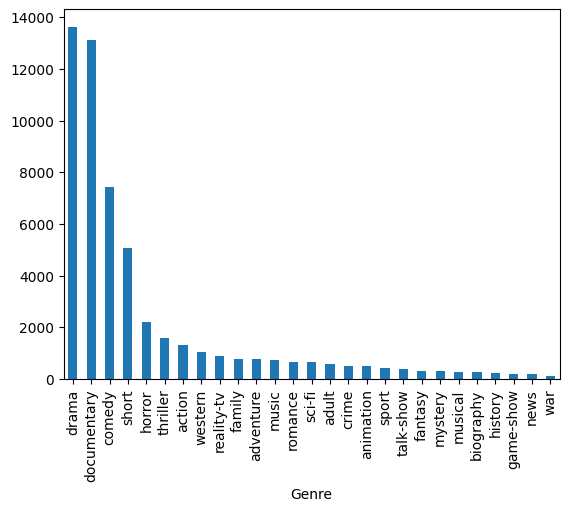

In [8]:
#data distribution
train_df['Genre'].value_counts().plot(kind='bar')

In [9]:
# TODO : write observations

# Data Preprocessing

In [10]:
#check for null values
train_df.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [11]:
test_df.isnull().sum()

Title          0
Description    0
dtype: int64

There is no null values in the data. We don't need to do any preprocessing for null values.

In [12]:
#check for duplicates
train_df.duplicated().sum()

0

In [13]:
test_df.duplicated().sum()

0

There are no duplicates in the data. We don't need to do any preprocessing for duplicates.

There is a class imbalance in the data. We need to do some preprocessing for class imbalance. We will use undersampling to balance the data and create several balanced datasets in order not to lose too much data.

In [14]:
#check how many values are there for each class
train_df['Genre'].value_counts()

Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64

In [15]:
# create n balanced datasets
n_datasets = 10
balanced_datasets = []
for i in range(n_datasets):
    balanced_datasets.append(train_df.groupby('Genre').apply(lambda x: x.sample(1000,replace = True)).reset_index(drop=True))

vectorize the data and remove stop words. We create two vectorizers, one for unigrams and one for bigrams and we will compare their performance.

In [16]:
vectorizer_unigram = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
synopses_tfidf_unigram = vectorizer_unigram.fit_transform(train_df['Description'])
synopses_tfidf_unigram_balanced = []
for i in range(n_datasets):
    synopses_tfidf_unigram_balanced.append(vectorizer_unigram.transform(balanced_datasets[i]['Description']))
vectorizer_bigram = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
synopses_tfidf_bigram = vectorizer_bigram.fit_transform(train_df['Description'])
synopses_tfidf_bigram_balanced = []
for i in range(n_datasets):
    synopses_tfidf_bigram_balanced.append(vectorizer_bigram.transform(balanced_datasets[i]['Description']))
vectorizer_unigram_bigram = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
synopses_tfidf_unigram_bigram = vectorizer_unigram_bigram.fit_transform(train_df['Description'])
synopses_tfidf_unigram_bigram_balanced = []
for i in range(n_datasets):
    synopses_tfidf_unigram_bigram_balanced.append(vectorizer_unigram_bigram.transform(balanced_datasets[i]['Description']))

# Model Building
we will use several models and compare their performance

In [17]:
def fit_kmeans(data, n_clusters=3, kmeans=None):
    """Fit a k-means classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        n_clusters (int): The number of clusters.
        kmeans: A k-means classifier to use. If None, a new classifier will be created.

    Returns:
        The trained k-means classifier.
    """
    if kmeans is None:
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(data)
    return kmeans

In [18]:
n_clusters = train_df['Genre'].nunique()
#load the models if they are already trained
if 'kmeans_unigram_{}.joblib'.format(n_clusters) in os.listdir('models'):
    kmeans_unigram = load('models/kmeans_unigram_{}.joblib'.format(n_clusters))
else:
    kmeans_unigram = None
if 'kmeans_bigram_{}.joblib'.format(n_clusters) in os.listdir('models'):
    kmeans_bigram = load('models/kmeans_bigram_{}.joblib'.format(n_clusters))
else:
    kmeans_bigram = None
if 'kmeans_unigram_balanced_{}.joblib'.format(n_clusters) in os.listdir('models'):
    kmeans_unigram_balanced = load('models/kmeans_unigram_balanced_{}.joblib'.format(n_clusters))
else:
    kmeans_unigram_balanced = None
if 'kmeans_bigram_balanced_{}.joblib'.format(n_clusters) in os.listdir('models'):
    kmeans_bigram_balanced = load('models/kmeans_bigram_balanced_{}.joblib'.format(n_clusters))
else:
    kmeans_bigram_balanced = None

In [19]:
#train the models if they are not already trained and save them
kmeans_unigram_trained = False
kmeans_bigram_trained = False
kmeans_unigram_balanced_trained = False
kmeans_bigram_balanced_trained = False
if kmeans_unigram is None:
    kmeans_unigram = fit_kmeans(synopses_tfidf_unigram, n_clusters=n_clusters)
    dump(kmeans_unigram, 'models/kmeans_unigram_{}.joblib'.format(n_clusters))
if kmeans_bigram is None:
    kmeans_bigram = fit_kmeans(synopses_tfidf_bigram, n_clusters=n_clusters)
    dump(kmeans_bigram, 'models/kmeans_bigram_{}.joblib'.format(n_clusters))
if kmeans_unigram_balanced is None:
    kmeans_unigram_balanced = fit_kmeans(synopses_tfidf_unigram_balanced[0], n_clusters=n_clusters)
    for i in range(1, n_datasets):
        kmeans_unigram_balanced = fit_kmeans(synopses_tfidf_unigram_balanced[i], kmeans=kmeans_unigram_balanced)
    dump(kmeans_unigram_balanced, 'models/kmeans_unigram_balanced_{}.joblib'.format(n_clusters))
if kmeans_bigram_balanced is None:
    kmeans_bigram_balanced = fit_kmeans(synopses_tfidf_bigram_balanced[0], n_clusters=n_clusters)
    for i in range(1, n_datasets):
        kmeans_bigram_balanced = fit_kmeans(synopses_tfidf_bigram_balanced[i], kmeans=kmeans_bigram_balanced)
    dump(kmeans_bigram_balanced, 'models/kmeans_bigram_balanced_{}.joblib'.format(n_clusters))

In [20]:
def fit_random_forest(data, labels, n_estimators=100, random_state=0, rf=None):
    """Fit a random forest classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        labels: The gold-standard labels.
        n_estimators (int): The number of trees in the forest.
        random_state (int): The random seed.

    Returns:
        The trained random forest classifier.
    """
    if rf is None:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(data, labels)
    return rf

In [21]:
#load the models if they are already trained
if 'rf_unigram_{}.joblib'.format(n_clusters) in os.listdir('models'):
    rf_unigram = load('models/rf_unigram_{}.joblib'.format(n_clusters))
else:
    rf_unigram = None
if 'rf_bigram_{}.joblib'.format(n_clusters) in os.listdir('models'):
    rf_bigram = load('models/rf_bigram_{}.joblib'.format(n_clusters))
else:
    rf_bigram = None
if 'rf_unigram_balanced_{}.joblib'.format(n_clusters) in os.listdir('models'):
    rf_unigram_balanced = load('models/rf_unigram_balanced_{}.joblib'.format(n_clusters))
else:
    rf_unigram_balanced = None
if 'rf_bigram_balanced_{}.joblib'.format(n_clusters) in os.listdir('models'):
    rf_bigram_balanced = load('models/rf_bigram_balanced_{}.joblib'.format(n_clusters))
else:
    rf_bigram_balanced = None

In [ ]:
#train the models if they are not already trained and save them
if rf_unigram is None:
    rf_unigram = fit_random_forest(synopses_tfidf_unigram, train_df['Genre'], n_estimators=100)
    dump(rf_unigram, 'models/rf_unigram_{}.joblib'.format(n_clusters))
if rf_bigram is None:
    rf_bigram = fit_random_forest(synopses_tfidf_bigram, train_df['Genre'], n_estimators=100)
    dump(rf_bigram, 'models/rf_bigram_{}.joblib'.format(n_clusters))
if rf_unigram_balanced is None:
    rf_unigram_balanced = fit_random_forest(synopses_tfidf_unigram_balanced[0], balanced_datasets[0]['Genre'], n_estimators=100)
    for i in range(1, n_datasets):
        rf_unigram_balanced = fit_random_forest(synopses_tfidf_unigram_balanced[i], balanced_datasets[i]['Genre'], n_estimators=100)
    dump(rf_unigram_balanced, 'models/rf_unigram_balanced_{}.joblib'.format(n_clusters))
if rf_bigram_balanced is None:
    rf_bigram_balanced = fit_random_forest(synopses_tfidf_bigram_balanced[0], balanced_datasets[0]['Genre'], n_estimators=100)
    for i in range(1, n_datasets):
        rf_bigram_balanced = fit_random_forest(synopses_tfidf_bigram_balanced[i], balanced_datasets[i]['Genre'], n_estimators=100)
    dump(rf_bigram_balanced, 'models/rf_bigram_balanced_{}.joblib'.format(n_clusters))

In [ ]:
#try to load the neural network model if it is already trained
if 'mlp_unigram_{}.joblib'.format(n_clusters) in os.listdir('models'):
    mlp_unigram = load('models/mlp_unigram_{}.joblib'.format(n_clusters))
else:
    mlp_unigram = None
if 'mlp_bigram_{}.joblib'.format(n_clusters) in os.listdir('models'):
    mlp_bigram = load('models/mlp_bigram_{}.joblib'.format(n_clusters))
else:
    mlp_bigram = None
if 'mlp_unigram_balanced_{}.joblib'.format(n_clusters) in os.listdir('models'):
    mlp_unigram_balanced = load('models/mlp_unigram_balanced_{}.joblib'.format(n_clusters))
else:
    mlp_unigram_balanced = None
if 'mlp_bigram_balanced_{}.joblib'.format(n_clusters) in os.listdir('models'):
    mlp_bigram_balanced = load('models/mlp_bigram_balanced_{}.joblib'.format(n_clusters))
else:
    mlp_bigram_balanced = None

In [ ]:
#train the neural network model if it is not already trained and save it
if mlp_unigram is None:
    mlp_unigram = MLPClassifier(random_state=1, max_iter=300).fit(synopses_tfidf_unigram, train_df['Genre'])
    dump(mlp_unigram, 'models/mlp_unigram_{}.joblib'.format(n_clusters))
if mlp_bigram is None:
    mlp_bigram = MLPClassifier(random_state=1, max_iter=300).fit(synopses_tfidf_bigram, train_df['Genre'])
    dump(mlp_bigram, 'models/mlp_bigram_{}.joblib'.format(n_clusters))
if mlp_unigram_balanced is None:
    mlp_unigram_balanced = MLPClassifier(random_state=1, max_iter=300).fit(synopses_tfidf_unigram_balanced[0], balanced_datasets[0]['Genre'])
    for i in range(1, n_datasets):
        mlp_unigram_balanced = MLPClassifier(random_state=1, max_iter=300).fit(synopses_tfidf_unigram_balanced[i], balanced_datasets[i]['Genre'])
    dump(mlp_unigram_balanced, 'models/mlp_unigram_balanced_{}.joblib'.format(n_clusters))
if mlp_bigram_balanced is None:
    mlp_bigram_balanced = MLPClassifier(random_state=1, max_iter=300).fit(synopses_tfidf_bigram_balanced[0], balanced_datasets[0]['Genre'])
    for i in range(1, n_datasets):
        mlp_bigram_balanced = MLPClassifier(random_state=1, max_iter=300).fit(synopses_tfidf_bigram_balanced[i], balanced_datasets[i]['Genre'])
    dump(mlp_bigram_balanced, 'models/mlp_bigram_balanced_{}.joblib'.format(n_clusters))

# Model Evaluation

In [24]:
def evaluate_model(model, data, labels):
    """Evaluate a model on some data using the Rand score.

    Arguments:
        model: The model to evaluate.
        data: The data to evaluate the model on.
        labels: The true labels for the data.

    Returns:
        The Rand score of the model on the data.
    """
    predictions = model.predict(data)
    return rand_score(labels, predictions)

In [27]:
print('K-means unigram: {}'.format(evaluate_model(kmeans_unigram, synopses_tfidf_unigram, train_df['Genre'])))
print('K-means bigram: {}'.format(evaluate_model(kmeans_bigram, synopses_tfidf_bigram, train_df['Genre'])))
print('K-means unigram balanced: {}'.format(evaluate_model(kmeans_unigram_balanced, synopses_tfidf_unigram_balanced[0], balanced_datasets[0]['Genre'])))
print('K-means bigram balanced: {}'.format(evaluate_model(kmeans_bigram_balanced, synopses_tfidf_bigram_balanced[0], balanced_datasets[0]['Genre'])))
print('Random forest unigram: {}'.format(evaluate_model(rf_unigram, synopses_tfidf_unigram, train_df['Genre'])))
print('Random forest bigram: {}'.format(evaluate_model(rf_bigram, synopses_tfidf_bigram, train_df['Genre'])))
print('Random forest unigram balanced: {}'.format(evaluate_model(rf_unigram_balanced, synopses_tfidf_unigram_balanced[0], balanced_datasets[0]['Genre'])))
# print('Random forest bigram balanced: {}'.format(evaluate_model(rf_bigram_balanced, synopses_tfidf_bigram_balanced[0], balanced_datasets[0]['Genre'])))
# print('Neural network unigram: {}'.format(evaluate_model(mlp_unigram, synopses_tfidf_unigram, train_df['Genre'])))
# print('Neural network bigram: {}'.format(evaluate_model(mlp_bigram, synopses_tfidf_bigram, train_df['Genre'])))
# print('Neural network unigram balanced: {}'.format(evaluate_model(mlp_unigram_balanced, synopses_tfidf_unigram_balanced[0], balanced_datasets[0]['Genre'])))
# print('Neural network bigram balanced: {}'.format(evaluate_model(mlp_bigram_balanced, synopses_tfidf_bigram_balanced[0], balanced_datasets[0]['Genre'])))

K-means unigram: 0.7998367156561139
K-means bigram: 0.44473694904979366
K-means unigram balanced: 0.8657950321891209
K-means bigram balanced: 0.2585904910058397
Random forest unigram: 0.9997599751147526
Random forest bigram: 0.9997599751147526
Random forest unigram balanced: 0.9791127737241297


In [28]:
# TODO : write observations

In [29]:
#predict the genres for the test data
gold_standard = test_df_solution['Genre']
print('K-means unigram: {}'.format(evaluate_model(kmeans_unigram, vectorizer_unigram.transform(test_df['Description']), gold_standard)))
print('K-means bigram: {}'.format(evaluate_model(kmeans_bigram, vectorizer_bigram.transform(test_df['Description']), gold_standard)))
print('K-means unigram balanced: {}'.format(evaluate_model(kmeans_unigram_balanced, vectorizer_unigram.transform(test_df['Description']), gold_standard)))
print('K-means bigram balanced: {}'.format(evaluate_model(kmeans_bigram_balanced, vectorizer_bigram.transform(test_df['Description']), gold_standard)))
print('Random forest unigram: {}'.format(evaluate_model(rf_unigram, vectorizer_unigram.transform(test_df['Description']), gold_standard)))
print('Random forest bigram: {}'.format(evaluate_model(rf_bigram, vectorizer_bigram.transform(test_df['Description']), gold_standard)))
print('Random forest unigram balanced: {}'.format(evaluate_model(rf_unigram_balanced, vectorizer_unigram.transform(test_df['Description']), gold_standard)))

K-means unigram: 0.7999640500713204
K-means bigram: 0.4361906195216494
K-means unigram balanced: 0.7416109057989047
K-means bigram balanced: 0.26011718738564166
Random forest unigram: 0.641967593933767
Random forest bigram: 0.5880565708072254
Random forest unigram balanced: 0.8204990465299771


In [ ]:
# TODO : write observations